# Проект: классификация

In [953]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [954]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [955]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [956]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [957]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [958]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [959]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# создаем функцию для преобразования
def balance_rework(arg):
    #убираем ненужное из аргумента и заменяем части строки для преобразования в вещественное число
    arg = str(arg).replace(',', '.')
    arg = arg.replace(' ','').strip(' $')
    return float(arg)

df['balance'] = df['balance'].apply(balance_rework) # заменяем столбец применяя к нему функцию
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [960]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df.balance.median())
round(df.balance.mean(), 3)

1526.936

### Задание 5

In [961]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
# сначала поменял значения на пропуски, а после все пропуски заполнил модальным значением
df.education = df['education'].replace('unknown', np.NAN)
df.job = df.job.replace('unknown', np.NAN)
df['education'] = df['education'].fillna(df.education.mode()[0])
df['job'] = df['job'].fillna(df['job'].mode()[0])
#так как мы знаем колл-ство популярных значений признака job смотрим популярные значения признака education
df.education.value_counts()



secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [962]:
# делаем сводную таблицу по этим признакам и находим по ним средний баланс
pt_df = pd.pivot_table(df,
                columns=['job', 'education'],
                values='balance',
                aggfunc=['mean'])
# теперь посмотрим средний баланс для самой популярной работы и самого популярного образования
display(round(pt_df.loc[:, (['mean'], ['management'], ['secondary'])], 3))


,mean
job,management
education,secondary
balance,1598.883


### Задание 6

In [963]:
# удалите все выбросы для признака balance
# ваш код

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound


outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница поиска выбросов: {lower_bound}')
print(f'Верхняя граница поиска выбросов: {upper_bound}')



Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница поиска выбросов: -2241.0
Верхняя граница поиска выбросов: 4063.0


In [964]:
# удаляем выбросы
df = df.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {cleaned.shape[0]}')

Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [965]:
df.deposit.value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

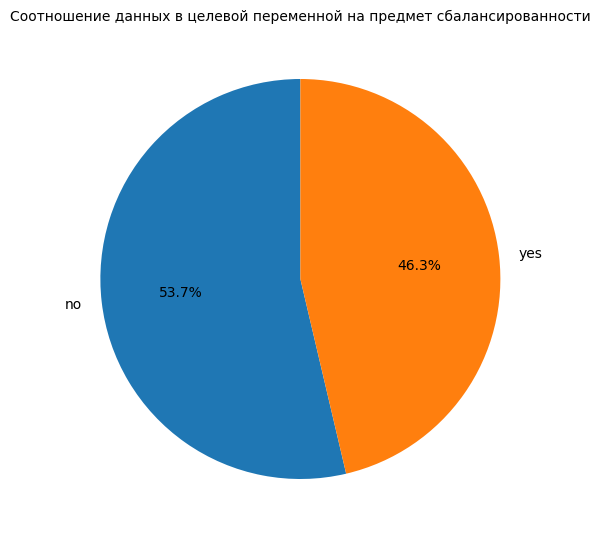

In [966]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
# рисую круговую диаграмму для того чтобы посмотреть соотношение классов в целевой переменной 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes((1, 1, 1, 1))
deposit_yes_count = df['deposit'].value_counts().sort_values(ascending=False)
pie = ax.pie(
    deposit_yes_count,
    labels=deposit_yes_count.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Соотношение данных в целевой переменной на предмет сбалансированности', fontsize=10)
plt.show(pie)

Вывод:  Соотношение классов имеет небольшой дисбаланс что не сильно повлияет при расчетах.

### Задания 2 и 3

In [967]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
# Посмотрим статистики
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


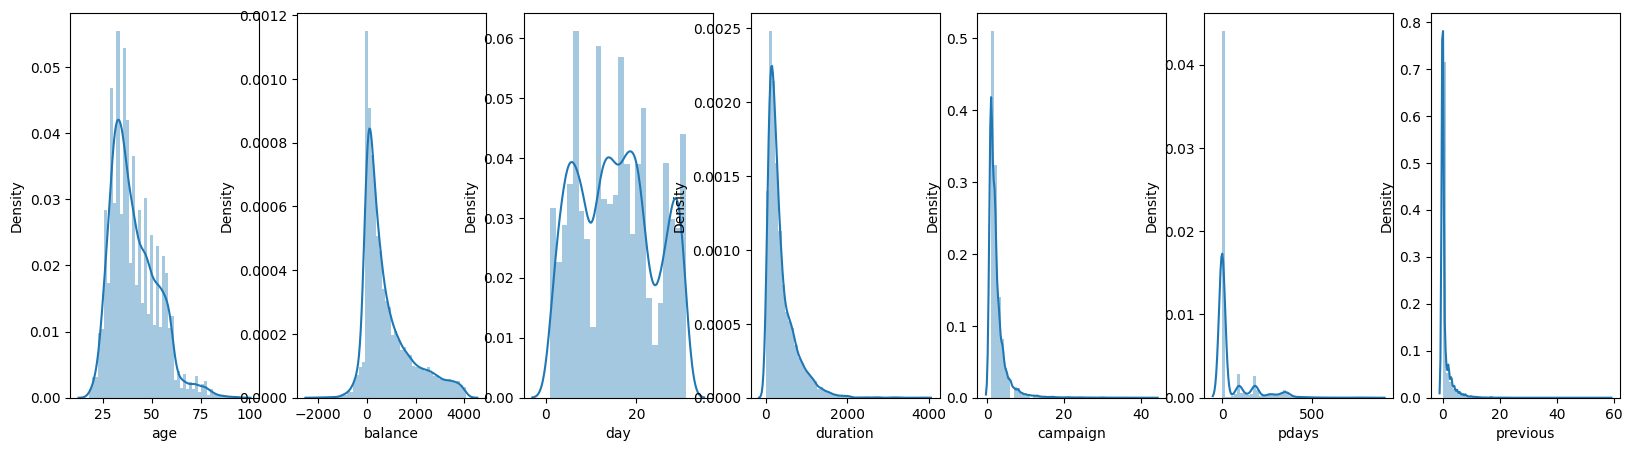

In [968]:
from pylab import *
# Построим графики гистограммы для просмотра распределения колличественных переменных
fig,axes=plt.subplots(1,7, figsize=[20, 5])
sns.distplot(df.age,ax=axes[0])
sns.distplot(df.balance,ax=axes[1])
sns.distplot(df.day,ax=axes[2])
sns.distplot(df.duration,ax=axes[3])
sns.distplot(df.campaign,ax=axes[4])
sns.distplot(df.pdays,ax=axes[5])
sns.distplot(df.previous,ax=axes[6])

plt.show()



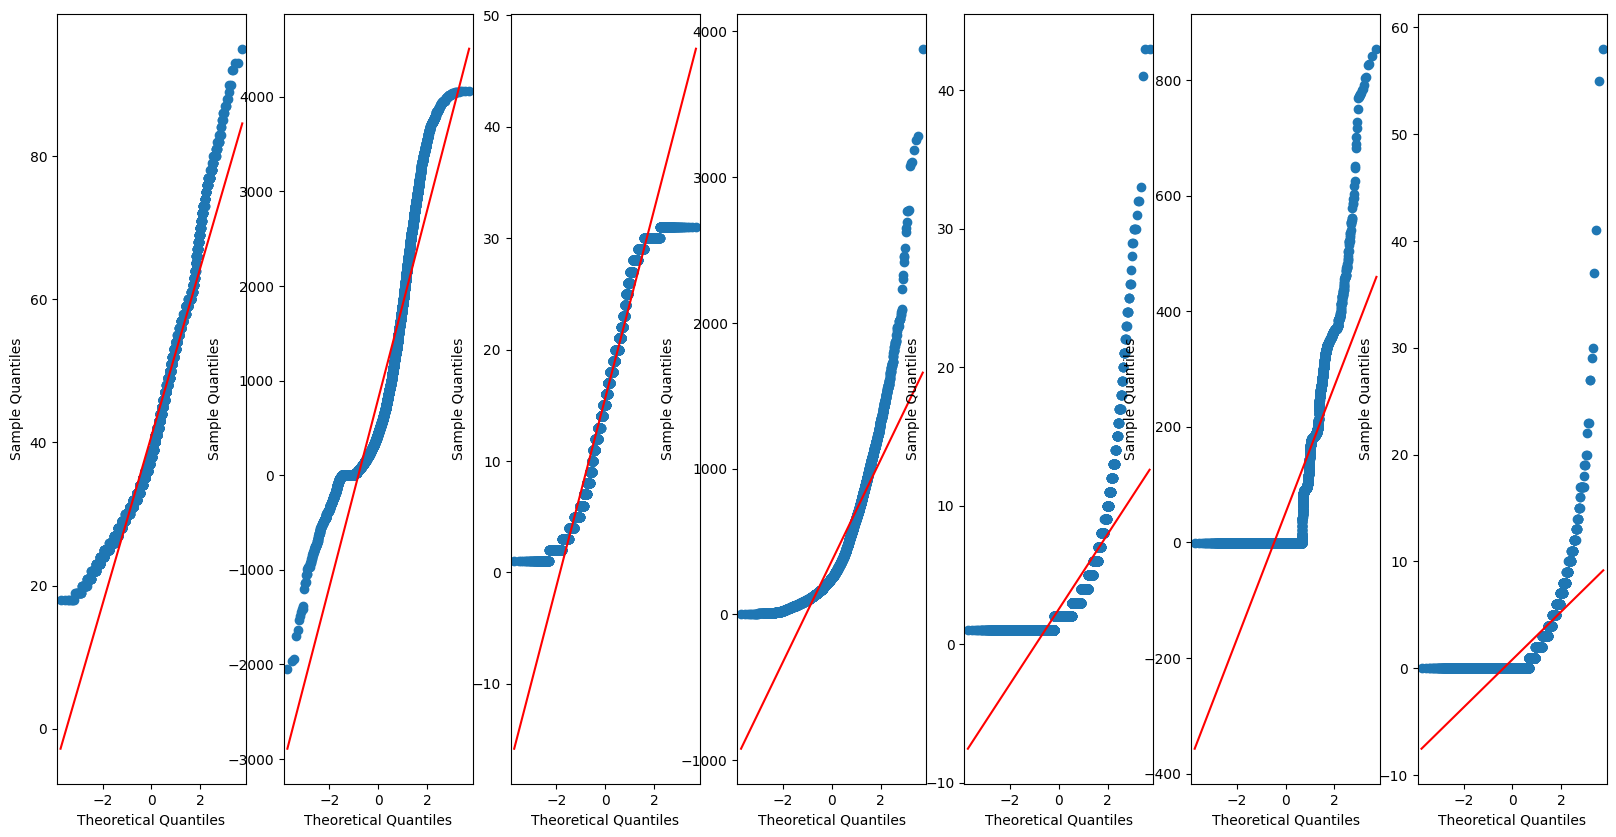

In [969]:
# Построим графики qqplot для просмотра распределения колличественных переменных
from statsmodels.graphics.gofplots import qqplot
fig,axes=plt.subplots(1,7, figsize=[20, 10])
qqplot(df.age, line='s', ax=axes[0])
qqplot(df.balance, line='s',ax=axes[1])
qqplot(df.day, line='s', ax=axes[2])
qqplot(df.duration,line='s',ax=axes[3])
qqplot(df.campaign,line='s',ax=axes[4])
qqplot(df.pdays,line='s',ax=axes[5])
qqplot(df.previous,line='s',ax=axes[6])

plt.show()

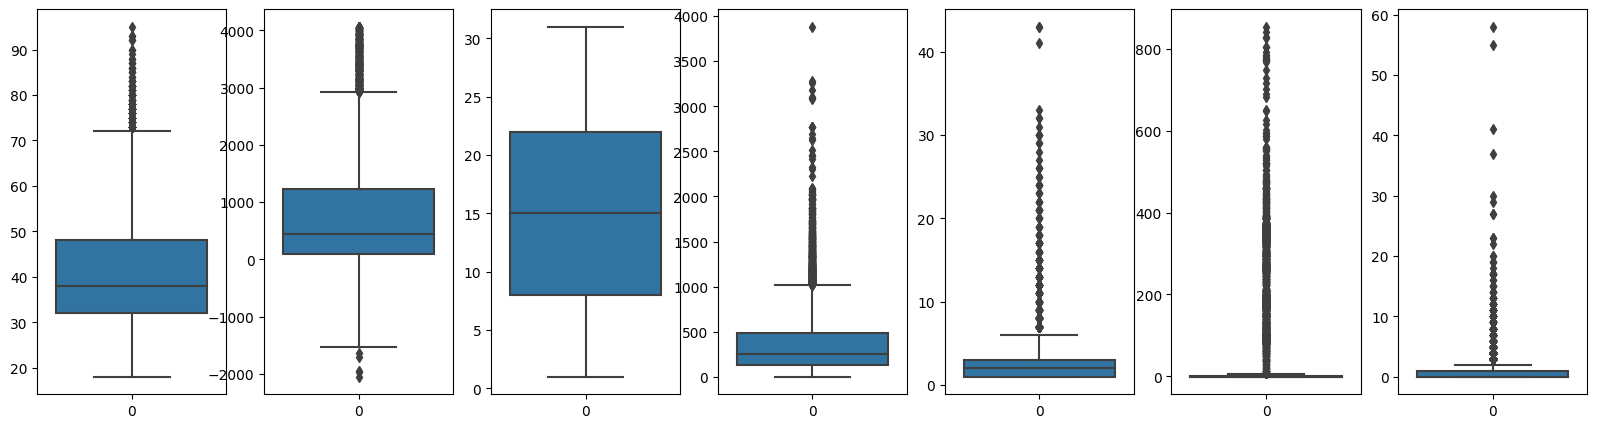

In [970]:
# Построим коробчатые диаграммы для просмотра возможных вобросов в данных
fig,axes=plt.subplots(1,7, figsize=[20, 5])
sns.boxplot(df.age,ax=axes[0])
sns.boxplot(df.balance,ax=axes[1])
sns.boxplot(df.day,ax=axes[2])
sns.boxplot(df.duration,ax=axes[3])
sns.boxplot(df.campaign,ax=axes[4])
sns.boxplot(df.pdays,ax=axes[5])
sns.boxplot(df.previous,ax=axes[6])

plt.show()

Вывод: Судя по максимальному возрасту заемщика и коробчатой диаграмме мы имеем аномальный возвраст который скорее всего является выбросами.Некоторые люди имеют отрицательный баланс на счету но это скорее всего не выброс а просто долг на балансе.Только три признака имеют более менее нормальное распределение(age,balance,day) хотя имеют хвосты все равно.В продолжительности контакта(duration) есть аномальные значения что видно и на коробчатой диаграмме и на описательной статистике,есть сомнения что разговор может быть более часа.А вот в колличестве пропущенных дней с начала контакта(pdays) лучше бы понять что означает -1 день это значит что еще не общались(?)так как очень большое колл-во данных содержится именно в этом диапазоне.Так же видно на графике qqplot что в предыдущую компанию(previous) очень мало контактов с большинством клиентов так как даже медиана показывает нулевое значение.

### Задания 4 и 5

In [971]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


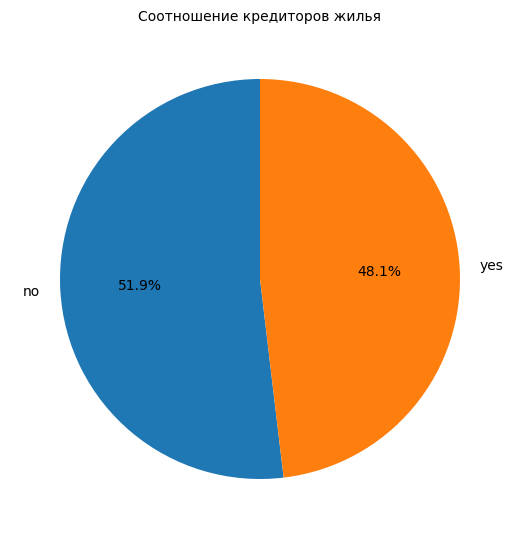

In [972]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes((1, 1, 1, 1))
deposit_yes_count = df['housing'].value_counts().sort_values(ascending=False)
pie = ax.pie(
    deposit_yes_count,
    labels=deposit_yes_count.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Соотношение кредиторов жилья', fontsize=10)
plt.show(pie)

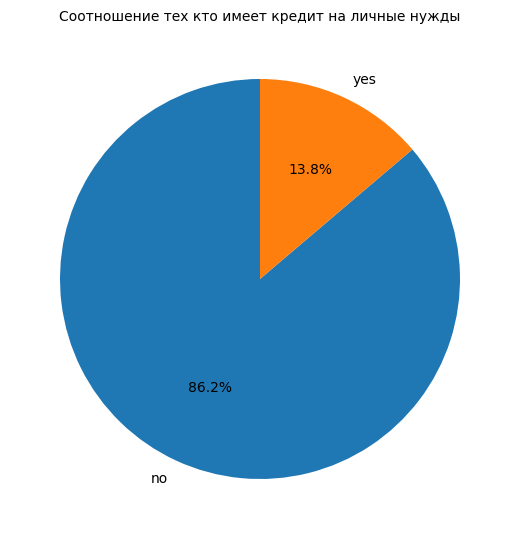

In [973]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes((1, 1, 1, 1))
deposit_yes_count = df['loan'].value_counts().sort_values(ascending=False)
pie = ax.pie(
    deposit_yes_count,
    labels=deposit_yes_count.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Соотношение тех кто имеет кредит на личные нужды', fontsize=10)
plt.show(pie)

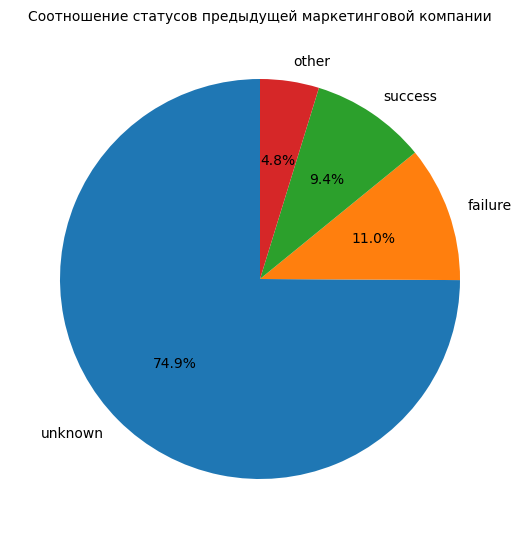

In [974]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes((1, 1, 1, 1))
deposit_yes_count = df['poutcome'].value_counts().sort_values(ascending=False)
pie = ax.pie(
    deposit_yes_count,
    labels=deposit_yes_count.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Соотношение статусов предыдущей маркетинговой компании', fontsize=10)
plt.show(pie)

Text(0.5, 0, 'Месяцы')

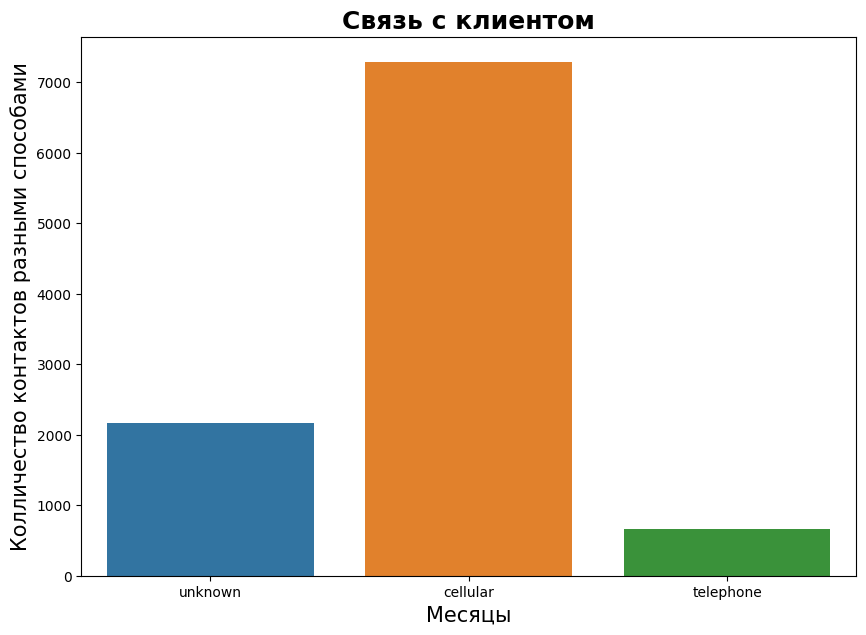

In [975]:
countplt, ax = plt.subplots(figsize = (10,7))
sns.countplot(df, x='contact')
ax.set_title('Связь с клиентом',fontsize = 18, fontweight='bold' )
ax.set_ylabel('Колличество контактов разными способами', fontsize = 15)
ax.set_xlabel('Месяцы', fontsize = 15)

Text(0.5, 0, 'Месяцы')

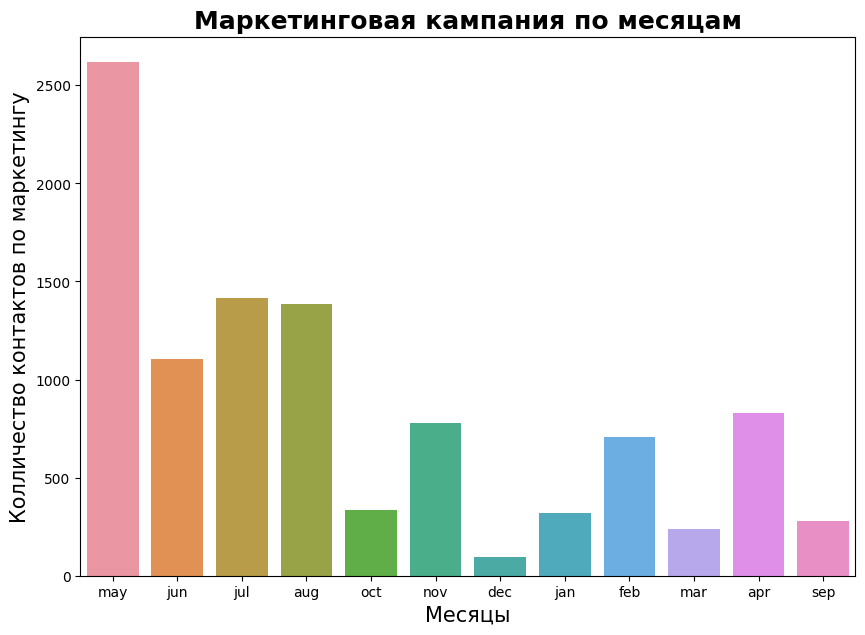

In [976]:
countplt, ax = plt.subplots(figsize = (10,7))
sns.countplot(df, x='month')
ax.set_title('Маркетинговая кампания по месяцам',fontsize = 18, fontweight='bold' )
ax.set_ylabel('Колличество контактов по маркетингу', fontsize = 15)
ax.set_xlabel('Месяцы', fontsize = 15)

Text(0.5, 0, 'Работы')

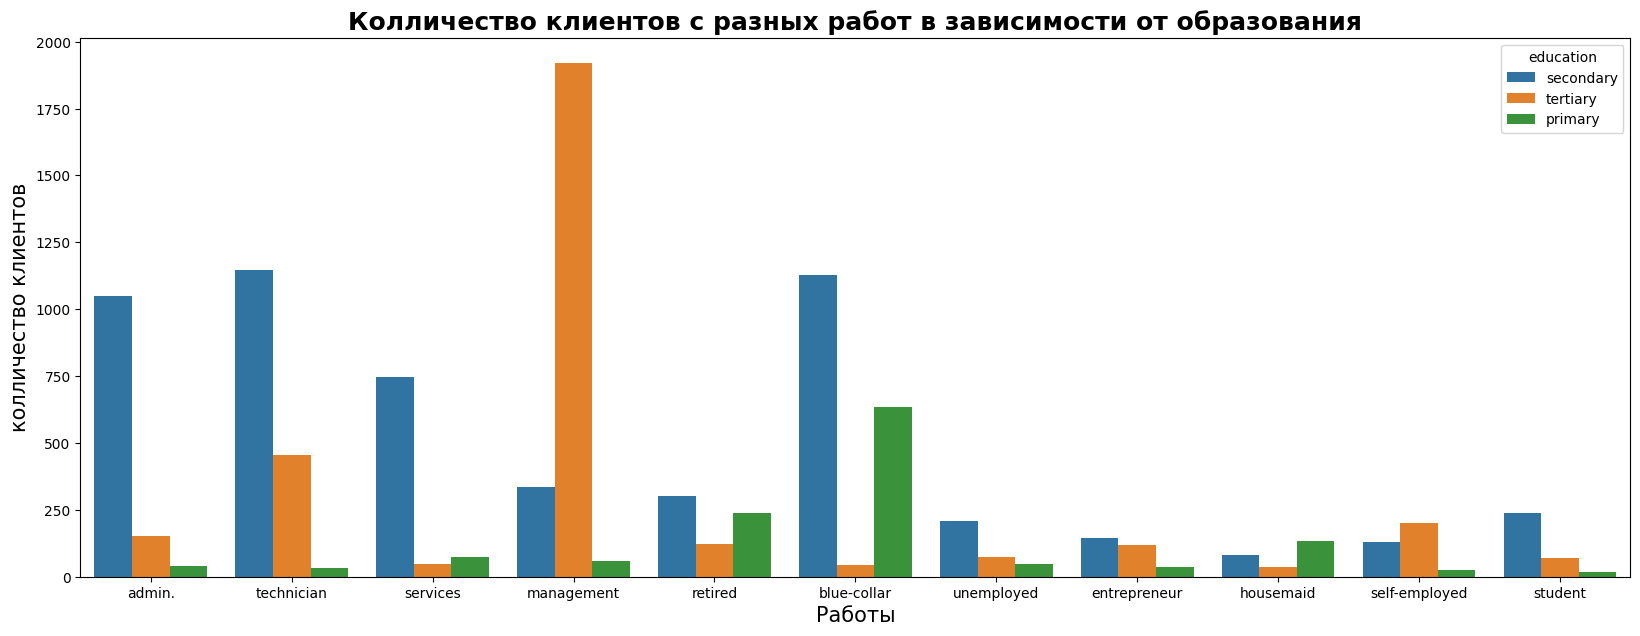

In [977]:
countplt, ax = plt.subplots(figsize = (20,7))
sns.countplot(df, x='job', hue='education')
ax.set_title('Колличество клиентов с разных работ в зависимости от образования',fontsize = 18, fontweight='bold' )
ax.set_ylabel('колличество клиентов', fontsize = 15)
ax.set_xlabel('Работы', fontsize = 15)

Вывод: Мы видим благодаря статистике и графику что самое большое колличество клиентов с которыми банк работает это руководящие люди с высшим образованием,так как они скорее всего более богатые.Также видим что люди со средним образованием занимают большую долю клиентов банка.Хотя в статистике мы видим что доминирующая строка про кредит на недвижимость(housing) что не берут,смотря на график мы понимаем что соотношение клиентов банка имеющих и не имеющих кредит на недвижимость примерно равна.А вот тех кто взял кредит на личные нужды(loan) очень мало чуть более 10 процентов.По графику мы видим что все месяцы ведется работа с предложениями к клиентам но в зимний и весенний период работники банка менее активны.Результат прошлой маркетинговой компании(poutcome) в статистике почти 2/3 значений представлены как unknown что означает что по большей части клиентов работа не велась так как этих клиентов возможно не было.В столбце контакт тоже имеются пропуски обозначены unknown и их тоже 1/4 от признака

### Задание 6

In [978]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
# сгруппируем данные по предыдущей маркетинговой компании с целевой переменной и подсчитаем значения
group_df = df.groupby(by='poutcome')['deposit'].value_counts()
display(group_df)

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

Вывод: Преобладает группа success которая в предыдущей маркетинговой компании умела успех судя по названию.В этой компании также в 10 раз больше по соотношению согласившихся чем отказавшихся в этой группе больше чем в других

### Задание 7

In [979]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
month_deposit = df.groupby(by='month')['deposit'].value_counts(normalize=True).unstack()
month_deposit

deposit,no,yes
month,,
apr,0.381928,0.618072
aug,0.559567,0.440433
dec,0.096774,0.903226
feb,0.455571,0.544429
jan,0.608150,0.391850
jul,0.589563,0.410437
jun,0.548913,0.451087
mar,0.101266,0.898734
may,0.678640,0.321360


Вывод: Чаще всего люди отказывались открыть депозит в мае месяце скорее всего из за сильной активности банка.Слишком они были навязчивы в этот месяц
потому и люди чаще отказывались.Хотя с другой стороны больше всего в этот месяц и соглашались открывать депозит.А судя по графику это был первый месяц новой маркетинговой компании потому скорее всего началась она бойко.Потом начала сбавлять темпы, видимо множественные отказы сделали свое дело и пошел отток клиентов.Либо стартовый сегмент кредиторов был найден а остальную часть года добирали планово.

### Задание 8

Text(0.5, 0, 'Возрастные группы')

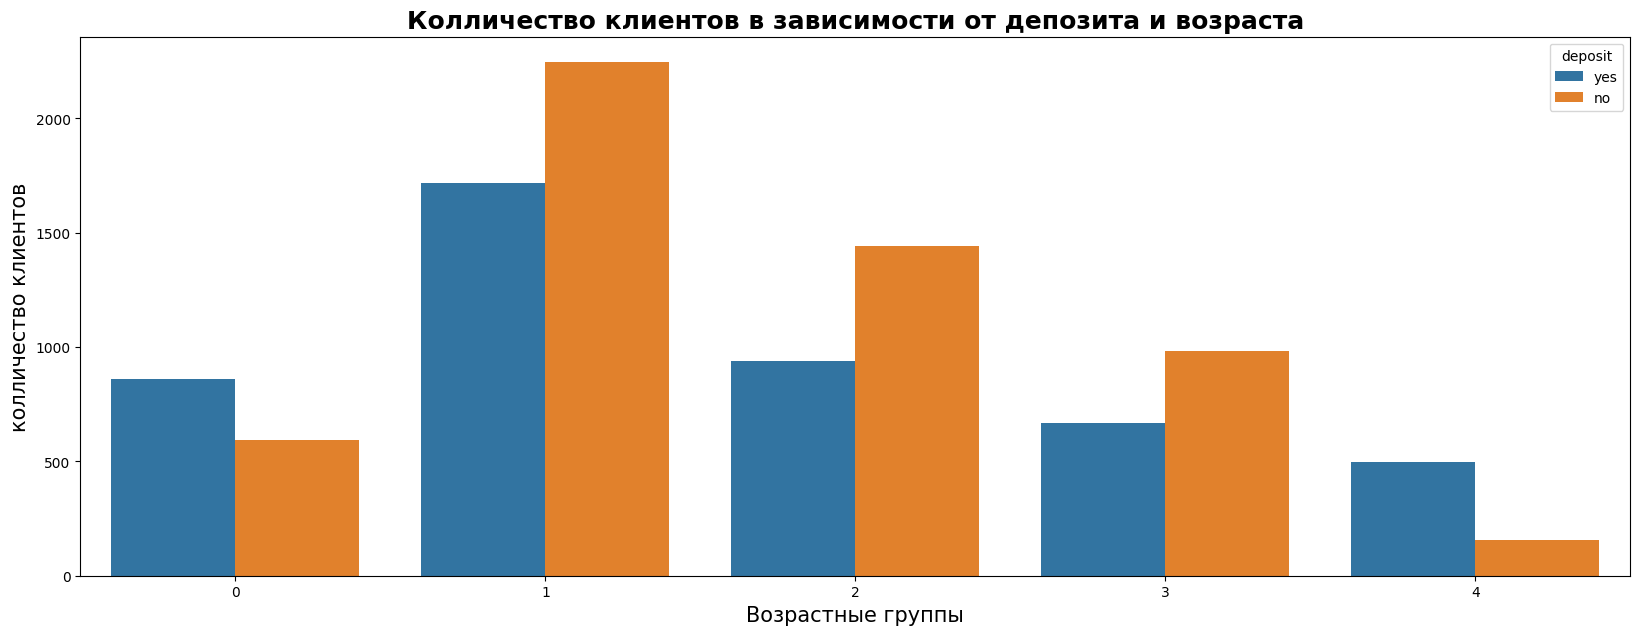

In [980]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# создаем функцию распределяющую возраст на категории
def age_group(arg):
    if arg < 30:
        return 0
    if arg < 40:
        return 1
    if arg < 50:
        return 2
    if arg < 60:
        return 3
    else:
        return 4
# создаем новый признак    
df['age_group'] = df['age'].apply(age_group)
# рисуем график зависимости склонных открывать депозит от возрастной группы
countplt, ax = plt.subplots(figsize = (20,7))
sns.countplot(df, x='age_group', hue='deposit')
ax.set_title('Колличество клиентов в зависимости от депозита и возраста',fontsize = 18, fontweight='bold' )
ax.set_ylabel('колличество клиентов', fontsize = 15)
ax.set_xlabel('Возрастные группы', fontsize = 15)

### Задания 9 и 10

Text(0.5, 0, 'Семейный статус')

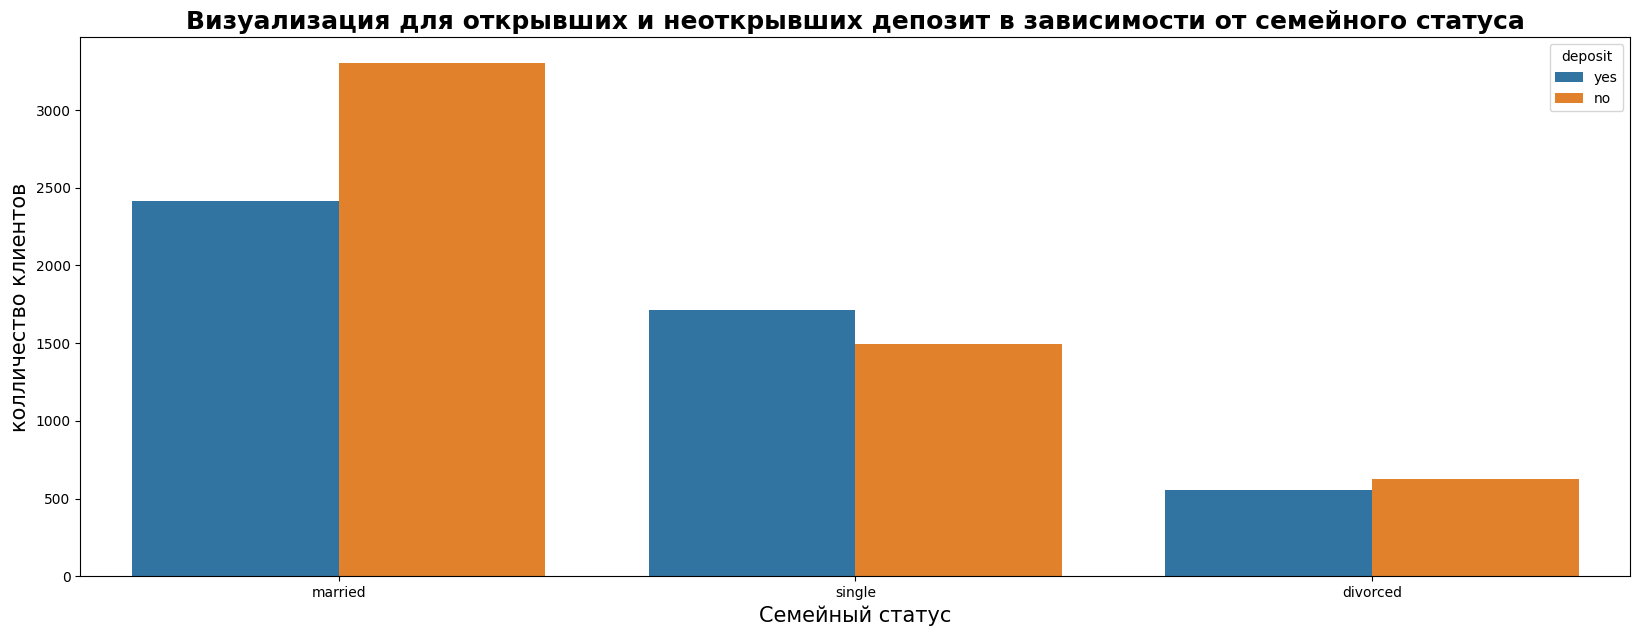

In [981]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
countplt, ax = plt.subplots(figsize = (20,7))
sns.countplot(df, x='marital', hue='deposit')
ax.set_title('Визуализация для открывших и неоткрывших депозит в зависимости от семейного статуса',fontsize = 18, fontweight='bold' )
ax.set_ylabel('колличество клиентов', fontsize = 15)
ax.set_xlabel('Семейный статус', fontsize = 15)


Вывод: Самая большая доля клиентов банка является семейными парами.В соотношении больше всего соглашаются открывать депозит а не отказываются от него те у кого еще не было семьи 

Text(0.5, 0, 'Образование')

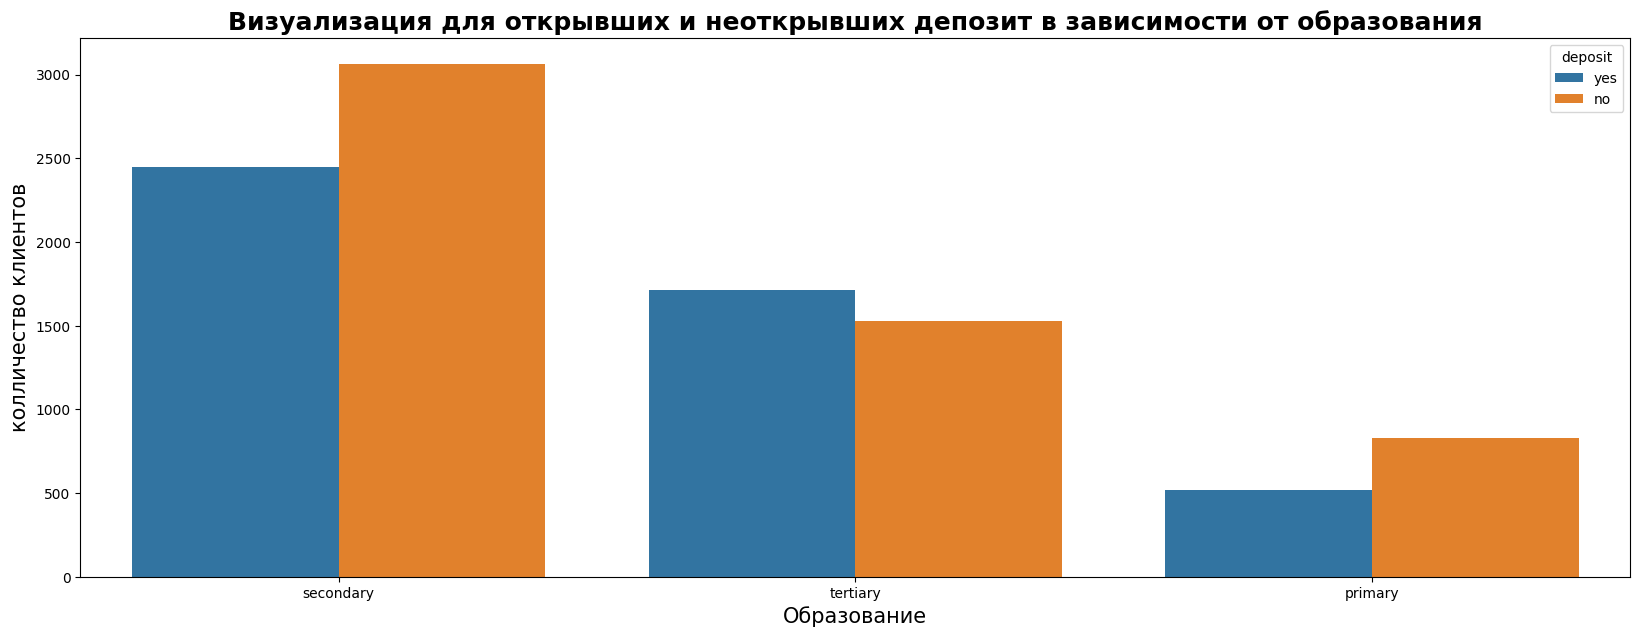

In [982]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
countplt, ax = plt.subplots(figsize = (20,7))
sns.countplot(df, x='education', hue='deposit')
ax.set_title('Визуализация для открывших и неоткрывших депозит в зависимости от образования',fontsize = 18, fontweight='bold' )
ax.set_ylabel('колличество клиентов', fontsize = 15)
ax.set_xlabel('Образование', fontsize = 15)

Вывод: Большая часть клиентов банка имеет среднее образование.В соотношении больше всего соглашаются открывать депозит а не отказываются от него люди с высшим образованием

Text(0.5, 0, 'Профессинальная занятость')

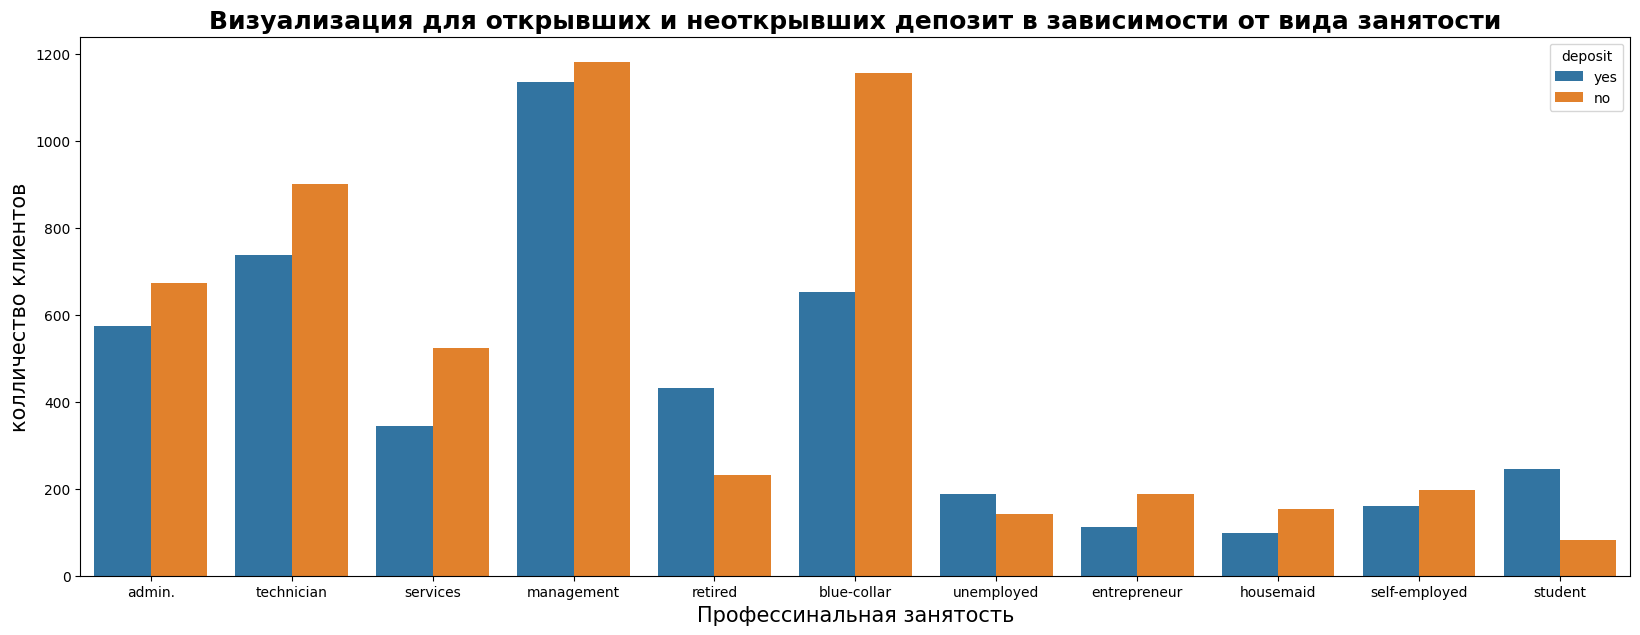

In [983]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
countplt, ax = plt.subplots(figsize = (20,7))
sns.countplot(df, x='job', hue='deposit')
ax.set_title('Визуализация для открывших и неоткрывших депозит в зависимости от вида занятости',fontsize = 18, fontweight='bold' )
ax.set_ylabel('колличество клиентов', fontsize = 15)
ax.set_xlabel('Профессинальная занятость', fontsize = 15)

Общий вывод : Больше всего готовы открыть счет одинокие люди не имевшие семьи с высшим образованием имеющие высшее образование.А большая часть клиентов банка имеют семью,имеют среднее или высшее образование  и работают на хороших местах в разных сферах деятельности

### Задание 11

In [984]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# делаю две сводные таблицы для тех кто открыл и для тех кто не открыл депозит
df_1 = df[df['deposit'] == 'no']
df_2 = df[df['deposit'] == 'yes']
pt_df2 = pd.pivot_table(df_1,
                columns=['education', 'marital'],
                values='deposit',
                aggfunc=['count'])
display(pt_df2)
pt_df3 = pd.pivot_table(df_2,
                columns=['education', 'marital'],
                values='deposit',
                aggfunc=['count'])
display(pt_df3)

count                                                           \
education  primary                secondary                tertiary           
marital   divorced married single  divorced married single divorced married   
deposit         91     641    100       370    1830    866      163     832   

                  
education         
marital   single  
deposit      531

count                                                           \
education  primary                secondary                tertiary           
marital   divorced married single  divorced married single divorced married   
deposit         96     339     82       283    1289    879      174     784   

                  
education         
marital   single  
deposit      755

<AxesSubplot: xlabel='None-education-marital'>

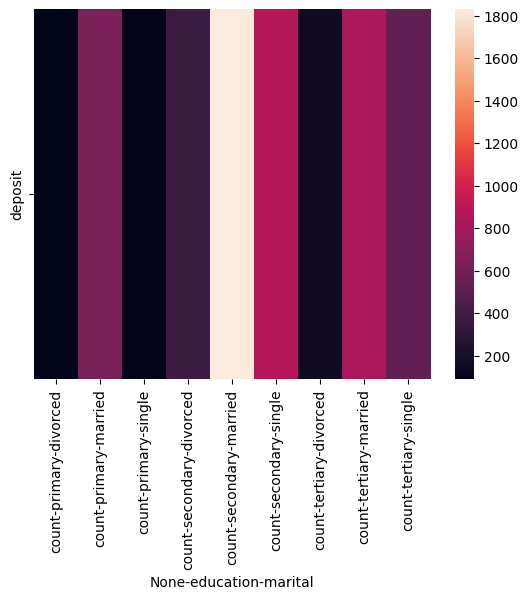

In [985]:
# строим тепловую карту для тех кто не открыл депозит
sns.heatmap(pt_df2)

<AxesSubplot: xlabel='None-education-marital'>

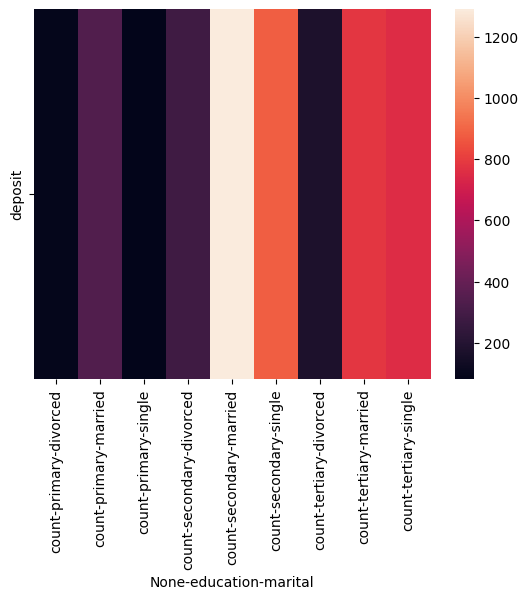

In [986]:
# строим тепловую карту для тех кто открыл депозит
sns.heatmap(pt_df3)

Вывод: Популярные группы для открывших депозит и не открывшими не различаются.Подтверждаем предыдущий вывод что больше всего банк работает с людьми семейными и имеющими среднее образование

## Часть 3: преобразование данных

### Задание 1

In [987]:
# преобразуйте уровни образования
le = preprocessing.LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df.education.sum()

11995

### Задания 2 и 3

In [988]:
# преобразуйте бинарные переменные в представление из нулей и единиц
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
df['deposit'] = lb.fit_transform(df['deposit'])
df.deposit.std()

0.4986712532452124

In [989]:
df['default'] = lb.fit_transform(df['default'])
df['housing'] = lb.fit_transform(df['housing'])
df['loan'] = lb.fit_transform(df['loan'])
sum_per = df.loan.mean() + df.housing.mean() + df.default.mean()
sum_per


0.6354280059376547

### Задание 4

In [990]:
# создайте дамми-переменные

df = pd.get_dummies(df, prefix=['job','marital','contact','month','poutcome'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int32  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int32  
 5   loan               10105 non-null  int32  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int32  
 12  age_group          10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

<AxesSubplot: >

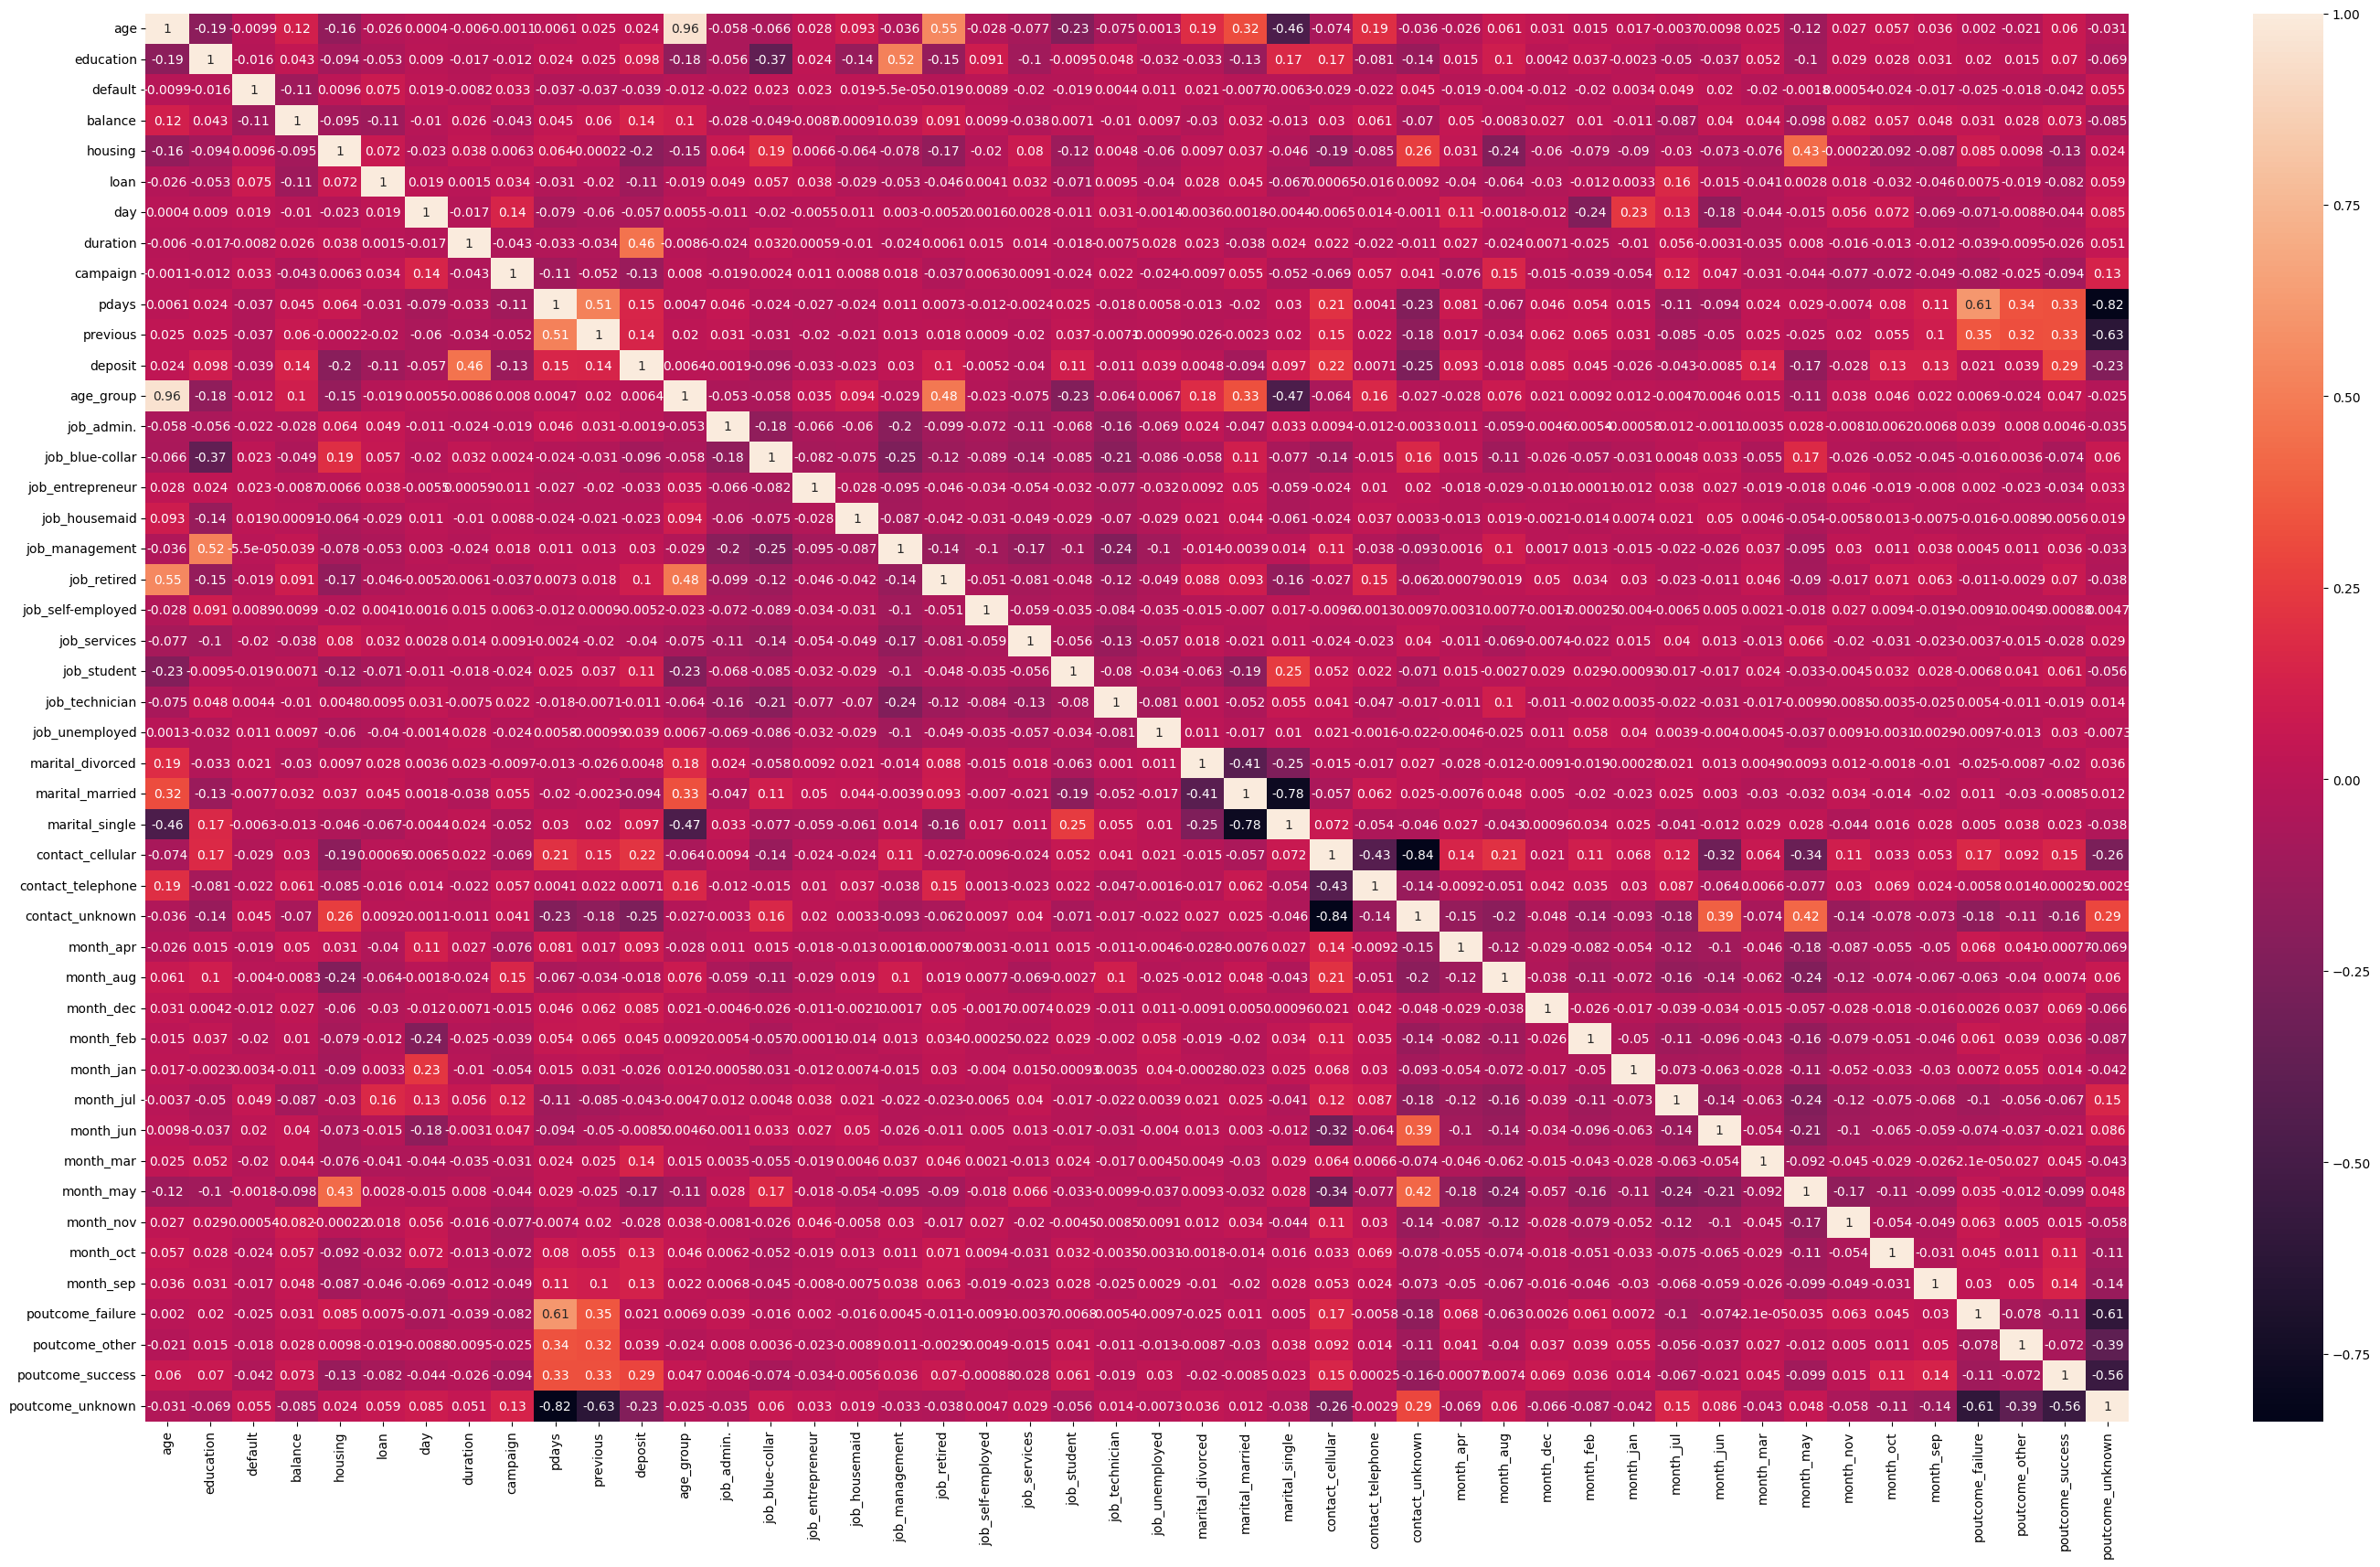

In [991]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig, ax = plt.subplots(figsize=(35,20))
sns.heatmap(df.corr(), annot=True)

In [992]:
df.corr()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,...,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,...,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.019845,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,...,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,...,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,...,-0.003061,-0.034640,0.007983,-0.015655,-0.012541,-0.012077,-0.039476,-0.009497,-0.025971,0.050571
campaign,-0.001143,-0.012280,0.033404,-0.042689,0.006257,0.033889,0.142169,-0.042576,1.000000,-0.105214,...,0.046763,-0.030574,-0.044348,-0.077307,-0.071519,-0.048672,-0.082282,-0.024854,-0.094260,0.134842
pdays,0.006107,0.024123,-0.037323,0.045155,0.064138,-0.030788,-0.078757,-0.033053,-0.105214,1.000000,...,-0.093551,0.024192,0.028678,-0.007350,0.079833,0.110907,0.608719,0.338049,0.326215,-0.824031


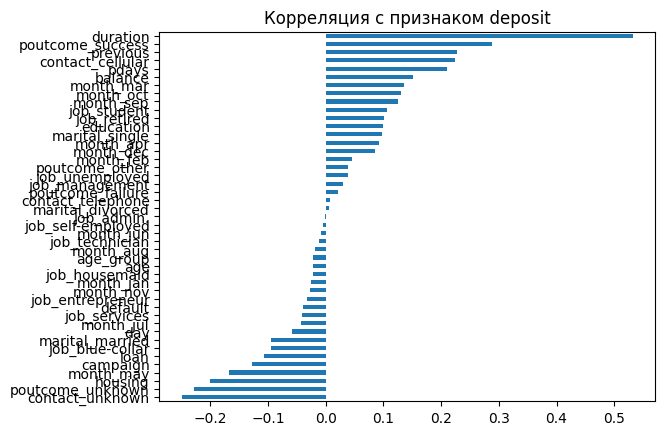

In [993]:
# Делаем корреляцию по рангам и по целевому признаку проходим функцией,сортируем значения и строим столбчатую диаграмму
df_corr = df.corr(method='spearman')
df_corr["deposit"].apply(lambda x: x).sort_values()[:-1].plot.barh()
plt.title("Корреляция с признаком deposit")
plt.show()

### Задания 7 и 8

In [994]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (6770, 45)
Test shape: (3335, 45)


In [995]:
# рассчитайте необходимые показатели
round(y_test.mean(), 2)

0.46

### Задание 9

In [996]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [997]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
round(X_test_scaled[:, 0].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [998]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
# расчитываем accuracy для тренировочных данных
y_train_pred = log_reg.predict(X_train_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
# расчитываем accuracy для тестовых данных
y_test_pred = log_reg.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy: 0.82
Accuracy: 0.80


### Задания 2,3,4

In [999]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)
# расчитываем accuracy для тренировочных данных
y_train_pred = dt.predict(X_train_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
# расчитываем accuracy для тестовых данных
y_test_pred = dt.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy: 0.82
Accuracy: 0.80


### Задание 5

In [1000]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)
y_train_pred = model_cv.predict(X_train_scaled)
#Рассчитываем F1-меру для тренировочных данных
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_cv.predict(X_test_scaled)
#Рассчитываем F1-меру для тестовых данных
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 score: 0.82
F1 score: 0.79


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [1001]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
# расчитываем accuracy для тренировочных данных
y_train_pred = rf.predict(X_train_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
# расчитываем accuracy для тестовых данных
y_test_pred = rf.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
# расчитываем recall для тренировочных данных
y_train_pred = rf.predict(X_train_scaled)
print('Recall: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
# расчитываем recall для тестовых данных
y_test_pred = rf.predict(X_test_scaled)
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))


Accuracy: 0.85
Accuracy: 0.83
Recall: 0.86
Recall: 0.83


### Задания 2 и 3

In [1002]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
y_train_pred = gb.predict(X_train_scaled)
#Рассчитываем F1-меру для тренировочных данных
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = gb.predict(X_test_scaled)
#Рассчитываем F1-меру для тестовых данных
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 score: 0.87
F1 score: 0.81


### Задание 4

In [1003]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)
y_train_pred = stack.predict(X_train_scaled)
#Рассчитываем precision для тренировочных данных
print('Precision: {:.2f}'.format(metrics.precision_score(y_train, y_train_pred)))
y_test_pred = stack.predict(X_test_scaled)
#Рассчитываем precision для тестовых данных
print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

Precision: 0.84
Precision: 0.81


### Задание 5

In [1004]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# это признаки (duration, poutcome_success, contact_unknown) так как они имеют лучшие значения корреляции с целевой переменной


### Задания 6,7,8

In [1005]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [1006]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2023-09-17 14:19:21,669] A new study created in memory with name: RandomForestClassifier


[I 2023-09-17 14:19:22,563] Trial 0 finished with value: 0.8429262205584152 and parameters: {'n_estimators': 142, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8429262205584152.
[I 2023-09-17 14:19:23,479] Trial 1 finished with value: 0.8633896728174911 and parameters: {'n_estimators': 132, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8633896728174911.
[I 2023-09-17 14:19:24,412] Trial 2 finished with value: 0.8447011081629467 and parameters: {'n_estimators': 134, 'max_depth': 21, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8633896728174911.
[I 2023-09-17 14:19:25,341] Trial 3 finished with value: 0.845074812967581 and parameters: {'n_estimators': 147, 'max_depth': 22, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8633896728174911.
[I 2023-09-17 14:19:26,604] Trial 4 finished with value: 0.8549190535491905 and parameters: {'n_estimators': 173, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.863

CPU times: total: 31.4 s
Wall time: 33.5 s


In [1007]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 154, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [1009]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81


## Вывод:
  
После оптимизации гиперпараметров с помощью структуры для автоматизированного поиска оптимальных гиперпараметров Optuna значения метрик стали самыми лучшими чем у других моделей